# DAMASK tutorial

- creating necessary inputs for damask
- defining the elastoplastic model (with powerlaw) for tensile test
- runing the damask jobs

here more option is given to the user to select from damask python package itself.

Author: Yang Bai

Date  : 23.02.2022

## Importing libraries and creatign Project

In [1]:
from pyiron_continuum import Project
%matplotlib inline

### create a 'project' to manage all the configurations for a tensile test

In [2]:
pr = Project('powerlaw') # automatically delete the existing project folder
pr.remove_jobs(silently=True) # automatically delete the existing project folder

0it [00:00, ?it/s]

### Creating the Damask job

In [3]:
job = pr.create.job.DAMASK('damask_job')

#### for a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

#### for the number of grains and grids

In [4]:
grains=4;grids=16

### For material configuration
#### for elastoplastic material

In [5]:
elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= 106.75e9,
                                   C_12= 60.41e9, C_44=28.34e9)
plasticity = pr.continuum.damask.Plasticity(type='phenopowerlaw',
                                            N_sl=[12],a_sl=[2.25],
                                            atol_xi=1.0,dot_gamma_0_sl=[0.001],
                                            h_0_sl_sl=[75.0e6],
                                            h_sl_sl=[1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                                            n_sl=[20],
                                            output=['xi_sl'],
                                            xi_0_sl=[31.0e6],
                                            xi_inf_sl=[63.0e6]
                                           )

#### for material configuration, you need
- phase
- roation
- homogenization

In [6]:
phase = pr.continuum.damask.Phase(composition='Aluminum', lattice= 'cF',
                         output_list=['F', 'P', 'F_e', 'F_p', 'L_p', 'O'],
                         elasticity=elasticity,plasticity=plasticity)
rotation = pr.continuum.damask.Rotation(shape=grains)

homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                     parameters={'N_constituents': 1,
                                                                 "mechanical": {"type": "pass"}})

# now you can define your material.yaml configuration
material = pr.continuum.damask.Material([rotation],['Aluminum'], phase, homogenization)

# now you can save your material to your job
job.material = material

/home/jovyan/dev/pyiron_continuum/pyiron_continuum/damask/damaskjob.py:165: UserWarning: Setting material via project creator is deprecated. Use job.set_material instead
  warnings.warn(


## For geometry information

In [7]:
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=1.0e-5, spatial_discretization=grids, num_grains=grains)

# save the geometry information to your job
job.grid = grid 

/home/jovyan/dev/pyiron_continuum/pyiron_continuum/damask/damaskjob.py:213: UserWarning: Setting grid via project creator is deprecated. Use job.set_grid instead
  warnings.warn(


## For boundary conditions (loading)

In [8]:
load_step =[{'mech_bc_dict':{'dot_F':[1e-3,0,0, 0,'x',0,  0,0,'x'],
                            'P':['x','x','x', 'x',0,'x',  'x','x',0]},
            'discretization':{'t': 10.,'N': 40},
            'additional': {'f_out': 4}
           },{'mech_bc_dict':{'dot_F':[1e-3,0,0, 0,'x',0,  0,0,'x'],
                              'P':['x','x','x', 'x',0,'x',  'x','x',0]},
            'discretization':{'t': 60.,'N': 60},
            'additional': {'f_out': 4}
           }]
solver = job.list_solvers()[0] # choose the mechanis solver
job.loading = pr.continuum.damask.Loading(solver=solver, load_steps=load_step)

/home/jovyan/dev/pyiron_continuum/pyiron_continuum/damask/damaskjob.py:224: UserWarning: Setting loading via project creator is deprecated. Use job.set_loading instead
  warnings.warn(


In [9]:
job.run() # running your job, if you want the parallelization you can modify your 'pyiron/damask/bin/run_damask_3.0.0.sh file'

The job damask_job was saved and received the ID: 7922


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varepsilon_z$$_z$', ylabel='$\\sigma_z$$_z$(Pa)'>)

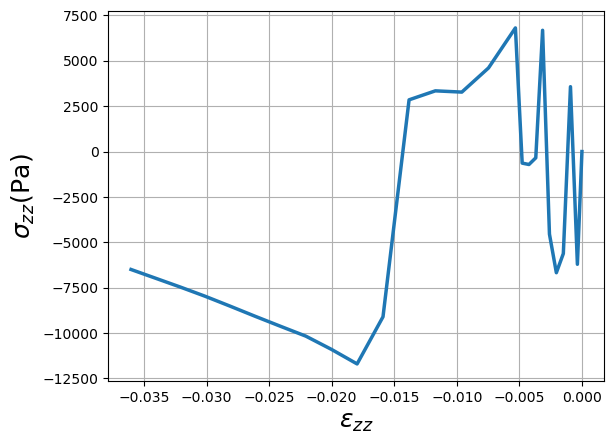

In [10]:
# plot the strain_xx vs stress_xx profile
job.plot_stress_strain(component='zz')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varepsilon_{vM}$', ylabel='$\\sigma_{vM}$ (Pa)'>)

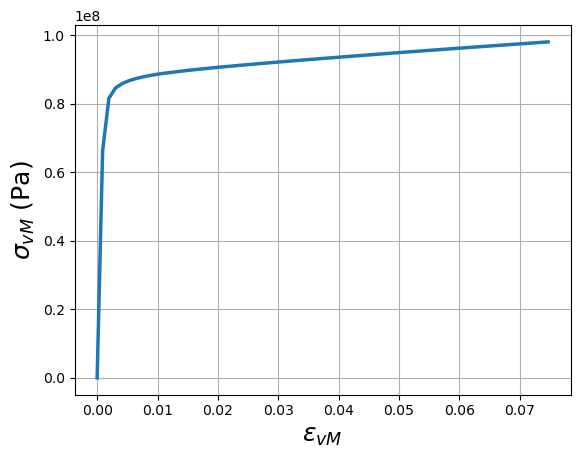

In [11]:
# plot the vonMises-strain vs vonMises-stress profile
job.plot_stress_strain(von_mises=True)